In [1]:
#Library yang sering digunakan
import  shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm import tqdm

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.15.0


In [6]:
import os

os.environ['KAGGLE_USERNAME'] = "melaniaintan"
os.environ['KAGGLE_KEY'] = "d29e6431a8dded186f2d86cd357ca075"

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

print(" Autentikasi ke Kaggle berhasil!")

print("Mengunduh dataset 'misrakahmed/vegetable-image-dataset'...")
api.dataset_download_files('misrakahmed/vegetable-image-dataset', path='.', unzip=True)
print("Dataset berhasil diunduh dan diekstrak!")


 Autentikasi ke Kaggle berhasil!
Mengunduh dataset 'misrakahmed/vegetable-image-dataset'...
Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
Dataset berhasil diunduh dan diekstrak!


In [7]:
# Direktori awal untuk train, test, dan validation
train_dir = "Vegetable Images/train"
test_dir = "Vegetable Images/test"
val_dir = "Vegetable Images/validation"

# Direktori baru kalau mau buat dataset gabungan
combined_dir = "Vegetable Images/combined_dataset"

print("Train folder:", train_dir)
print("Test folder:", test_dir)
print("Validation folder:", val_dir)


Train folder: Vegetable Images/train
Test folder: Vegetable Images/test
Validation folder: Vegetable Images/validation


In [8]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [9]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [10]:
#  Hapus semua folder _augmented lama ---
base_path = "Vegetable Images/combined_dataset"

for folder in os.listdir(base_path):
    full_path = os.path.join(base_path, folder)
    if os.path.isdir(full_path) and folder.endswith("_augmented"):
        shutil.rmtree(full_path)
        print(f"Dihapus folder lama: {folder}")

print(" Semua folder _augmented lama dihapus sebelum proses dimulai.\n")

 Semua folder _augmented lama dihapus sebelum proses dimulai.



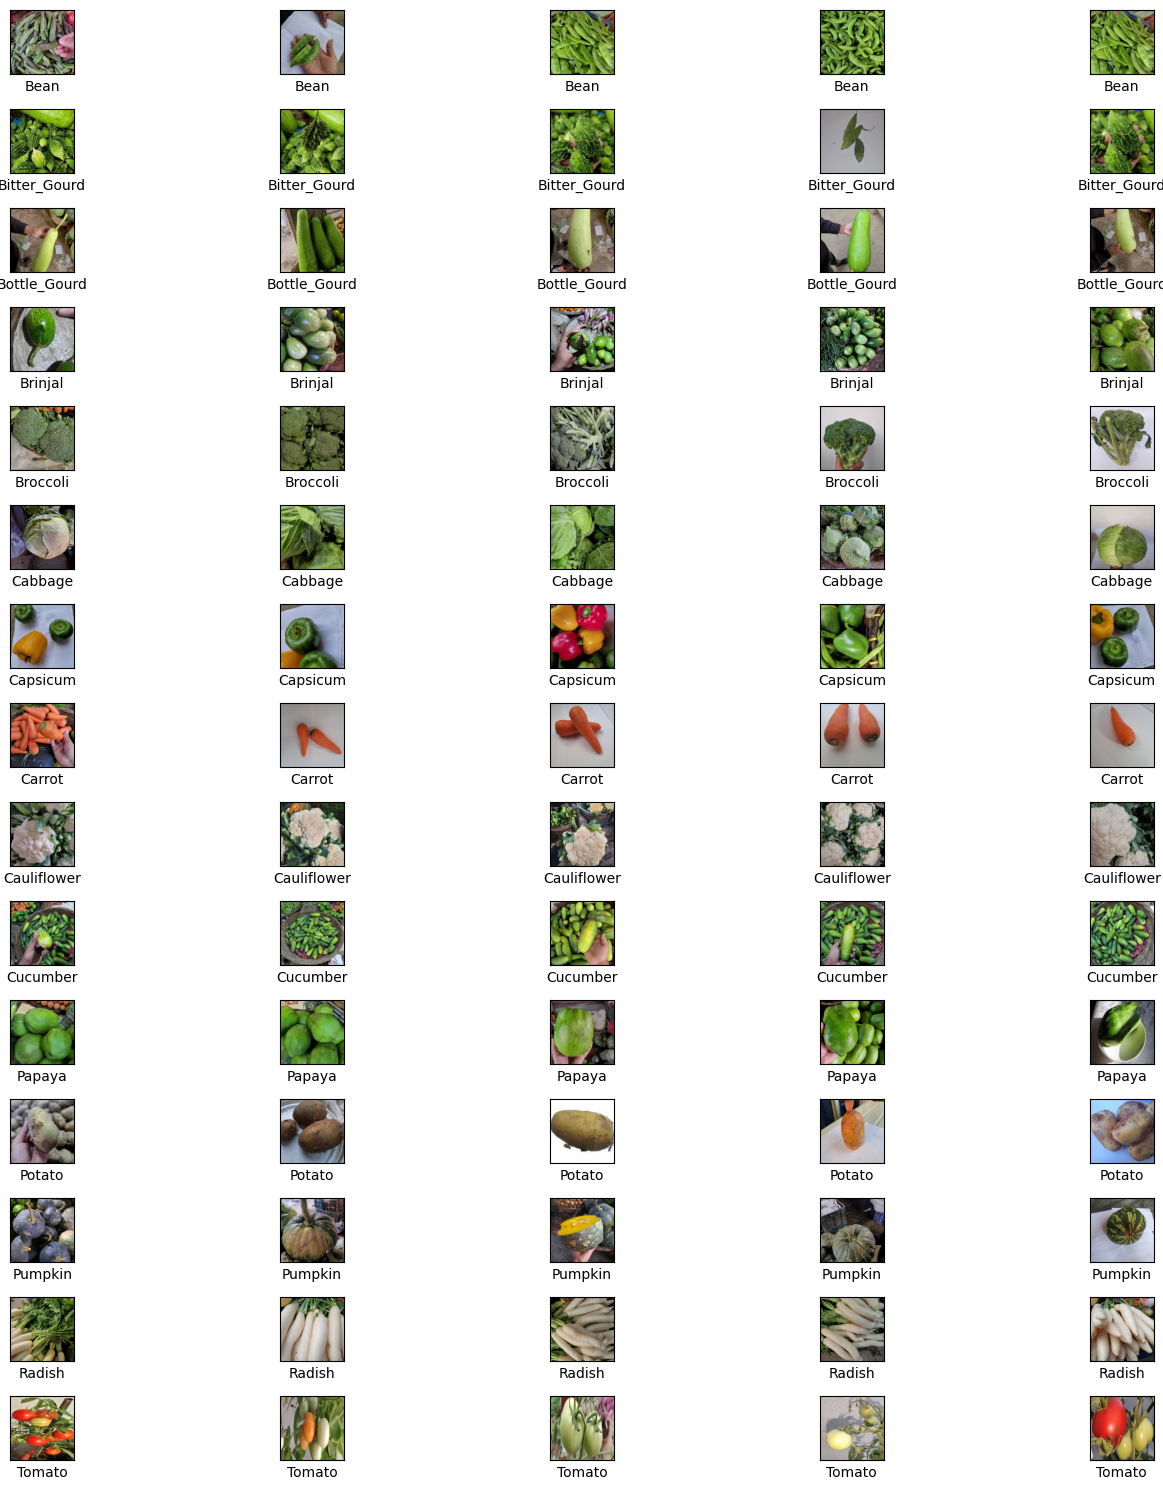

In [11]:

# Tentukan path sumber dataset
path = "Vegetable Images/"
path_sub = os.path.join(path, "combined_dataset")

# Hapus folder kosong di combined_dataset
for folder in os.listdir(path_sub):
    folder_path = os.path.join(path_sub, folder)
    if os.path.isdir(folder_path) and len(os.listdir(folder_path)) == 0:
        print(f"🗑 Menghapus folder kosong: {folder_path}")
        os.rmdir(folder_path)

# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
veg_image = {}

# Simpan nama file gambar per kelas
for i in os.listdir(path_sub):
    veg_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan
path_sub = "Vegetable Images/combined_dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(veg_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    # Lewati folder kosong kalau masih ada
    if len(veg_image[class_name]) == 0:
        print(f" Folder kosong: {class_name}, dilewati.")
        continue

    # Pilih maksimal 5 gambar acak dari tiap kelas
    num_samples = min(5, len(veg_image[class_name]))
    images = np.random.choice(veg_image[class_name], num_samples, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # dataset sayur berwarna
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


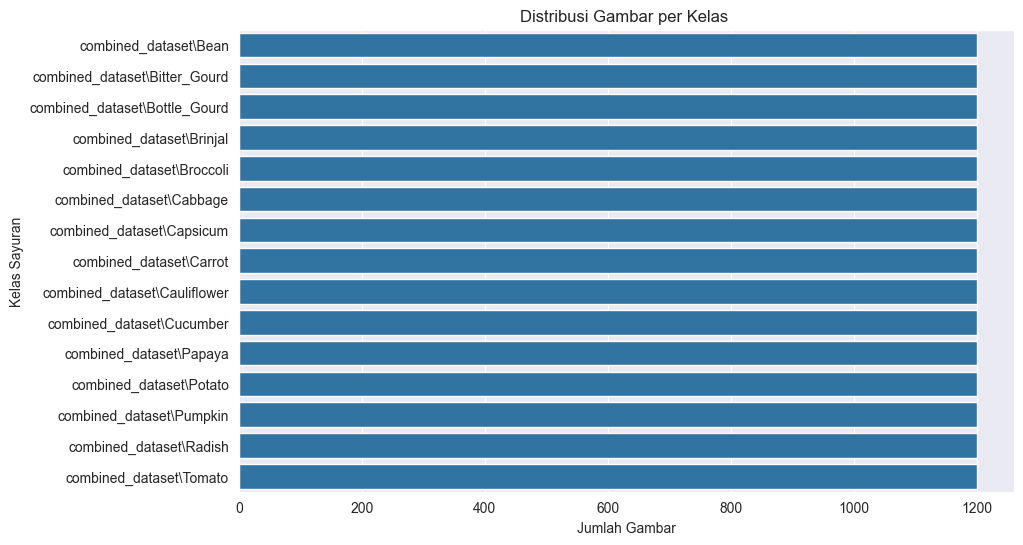

In [12]:
# Definisikan path sumber
veg_path = "Vegetable Images/combined_dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Looping untuk ambil nama file, path, dan label
for path, subdirs, files in os.walk(veg_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # nama folder terakhir jadi label
        file_name.append(name)

# Simpan dalam DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
sns.countplot(y=Label, order=Label.value_counts().index)
plt.title("Distribusi Gambar per Kelas ")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas Sayuran")
plt.show()

In [13]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [14]:

# Membuat kamus transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

# Path utama dataset sayur
base_path = "Vegetable Images/train"

# Jumlah gambar augmentasi per kelas
images_to_generate = 2000

# Loop semua folder kelas di train (misal: Bean, Broccoli, Cabbage, dll)
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)

    # Lewati jika bukan folder
    if not os.path.isdir(class_path):
        continue

    # Lewati folder hasil augmentasi lama agar tidak dobel
    if class_name.endswith("_augmented"):
        print(f" Lewati folder augmentasi lama: {class_name}")
        continue

    # Buat folder tujuan untuk augmentasi
    augmented_path = os.path.join(base_path, f"{class_name}_augmented")
    os.makedirs(augmented_path, exist_ok=True)

    # Ambil semua gambar valid (jpg, png, dll)
    images = [
        os.path.join(class_path, im)
        for im in os.listdir(class_path)
        if im.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    print(f"\n Mulai augmentasi untuk kelas: {class_name} ({len(images)} gambar ditemukan)")

    i = 1
    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)
            transformed_image = None
            n = 0
            transformation_count = random.randint(1, len(transformations))

            while n <= transformation_count:
                key = random.choice(list(transformations))
                transformed_image = transformations[key](original_image)
                n += 1

            new_image_path = f"{augmented_path}/augmented_image_{i}.jpg"
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i += 1

        except Exception as e:
            print(f" Gagal memproses {image}: {e}")
            continue

    print(f" Augmentasi selesai untuk {class_name}: {i-1} gambar disimpan di {augmented_path}")

print("\n Semua kelas sayur telah berhasil di-augmentasi!")



 Mulai augmentasi untuk kelas: Bean (1000 gambar ditemukan)
 Augmentasi selesai untuk Bean: 2000 gambar disimpan di Vegetable Images/train\Bean_augmented

 Mulai augmentasi untuk kelas: Bitter_Gourd (1000 gambar ditemukan)
 Augmentasi selesai untuk Bitter_Gourd: 2000 gambar disimpan di Vegetable Images/train\Bitter_Gourd_augmented

 Mulai augmentasi untuk kelas: Bottle_Gourd (1000 gambar ditemukan)
 Augmentasi selesai untuk Bottle_Gourd: 2000 gambar disimpan di Vegetable Images/train\Bottle_Gourd_augmented

 Mulai augmentasi untuk kelas: Brinjal (1000 gambar ditemukan)
 Augmentasi selesai untuk Brinjal: 2000 gambar disimpan di Vegetable Images/train\Brinjal_augmented

 Mulai augmentasi untuk kelas: Broccoli (1000 gambar ditemukan)
 Augmentasi selesai untuk Broccoli: 2000 gambar disimpan di Vegetable Images/train\Broccoli_augmented

 Mulai augmentasi untuk kelas: Cabbage (1000 gambar ditemukan)
 Augmentasi selesai untuk Cabbage: 2000 gambar disimpan di Vegetable Images/train\Cabbage_au

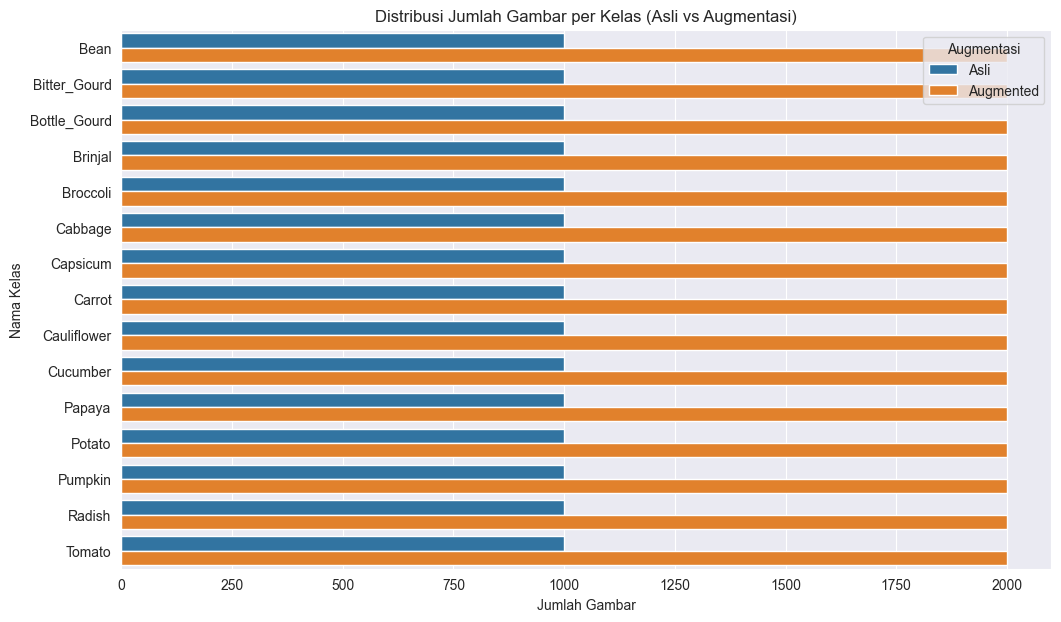

In [15]:
# Path utama (train berisi folder augmented dan asli)
veg_path = "Vegetable Images/train/"

# Buat daftar yang menyimpan data untuk setiap gambar
file_name = []
labels = []
full_path = []

# Loop semua subfolder (kelas + augmented)
for path, subdirs, files in os.walk(veg_path):
    for name in files:
        if not name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # nama folder jadi label
        file_name.append(name)

# Simpan ke DataFrame
distribution_train = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Tambahkan kolom untuk menandai apakah ini hasil augmentasi atau bukan
distribution_train["is_augmented"] = distribution_train["labels"].apply(
    lambda x: "_augmented" in x
)

# Ganti label augmented agar lebih rapi (hapus _augmented)
distribution_train["clean_labels"] = distribution_train["labels"].str.replace("_augmented", "", regex=False)

# Plot distribusi gambar per kelas (asli + augmented)
plt.figure(figsize=(12, 7))
sns.set_style("darkgrid")
plot_data = sns.countplot(
    y='clean_labels',
    data=distribution_train,
    hue='is_augmented',  # bedakan asli vs augmented
    order=distribution_train['clean_labels'].value_counts().index
)
plt.title("Distribusi Jumlah Gambar per Kelas (Asli vs Augmentasi)")
plt.xlabel("Jumlah Gambar")
plt.ylabel("Nama Kelas")
plt.legend(title="Augmentasi", labels=["Asli", "Augmented"])
plt.show()

In [16]:
mypath = "Vegetable Images/train/" 

file_name = []
labels = []
full_path = []

# Loop semua subfolder dan file di dalamnya
for path, subdirs, files in os.walk(mypath):
    for name in files:
        # Lewati file non-gambar
        if not name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # ambil nama folder (kelas)
        file_name.append(name)

# Simpan dalam DataFrame agar rapi
df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Melihat jumlah gambar di setiap label (kelas)
print(df.groupby(['labels']).size())


labels
Bean                      1000
Bean_augmented            2000
Bitter_Gourd              1000
Bitter_Gourd_augmented    2000
Bottle_Gourd              1000
Bottle_Gourd_augmented    2000
Brinjal                   1000
Brinjal_augmented         2000
Broccoli                  1000
Broccoli_augmented        2000
Cabbage                   1000
Cabbage_augmented         2000
Capsicum                  1000
Capsicum_augmented        2000
Carrot                    1000
Carrot_augmented          2000
Cauliflower               1000
Cauliflower_augmented     2000
Cucumber                  1000
Cucumber_augmented        2000
Papaya                    1000
Papaya_augmented          2000
Potato                    1000
Potato_augmented          2000
Pumpkin                   1000
Pumpkin_augmented         2000
Radish                    1000
Radish_augmented          2000
Tomato                    1000
Tomato_augmented          2000
dtype: int64


In [17]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels

X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [18]:
# Menyatukan ke dalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [19]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('=====================================================')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('=====================================================')

# Cek sampel data
print(df_all.sample(5))

# Path dataset asli dan dataset hasil split
datasource_path = "Vegetable Images/combined_dataset/"
dataset_path = "Vegetable Images/Dataset-Final/"  # bisa diganti nama sesuai kebutuhan


set    labels                
test   Bean                       199
       Bean_augmented             382
       Bitter_Gourd               209
       Bitter_Gourd_augmented     398
       Bottle_Gourd               209
       Bottle_Gourd_augmented     420
       Brinjal                    199
       Brinjal_augmented          425
       Broccoli                   211
       Broccoli_augmented         408
       Cabbage                    192
       Cabbage_augmented          362
       Capsicum                   202
       Capsicum_augmented         412
       Carrot                     200
       Carrot_augmented           354
       Cauliflower                217
       Cauliflower_augmented      378
       Cucumber                   217
       Cucumber_augmented         410
       Papaya                     212
       Papaya_augmented           381
       Potato                     203
       Potato_augmented           386
       Pumpkin                    224
       Pumpkin_augme

In [20]:

# Loop semua baris di df_all dengan progress bar
for index, row in tqdm(df_all.iterrows(), total=len(df_all)):
    # Deteksi file path
    file_path = row['path']

    # Jika path tidak ditemukan (antisipasi error)
    if not os.path.exists(file_path):
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])
        if not os.path.exists(file_path):
            print(f" File tidak ditemukan: {file_path}")
            continue

    # Buat direktori tujuan (misalnya Dataset-Final/train/Cabbage/)
    target_dir = os.path.join(dataset_path, row['set'], row['labels'])
    os.makedirs(target_dir, exist_ok=True)

    # Tentukan nama file tujuan
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(target_dir, destination_file_name)

    # Salin file dari sumber ke tujuan
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)


100%|██████████| 45000/45000 [03:43<00:00, 200.90it/s]


In [21]:
BASE_DIR = "Vegetable Images/Dataset-Final/"
TRAIN_DIR = os.path.join(BASE_DIR, "train/")
TEST_DIR = os.path.join(BASE_DIR, "test/")
VAL_DIR = os.path.join(BASE_DIR, "val/")  


def count_images_per_class(directory):
    counts = {}
    if not os.path.exists(directory):
        return counts
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
    return counts

# --- Fungsi untuk buat validation split (misal 20%) ---
def create_validation_split(train_dir, val_dir, val_ratio=0.2):
    os.makedirs(val_dir, exist_ok=True)
    
    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_train_path):
            continue
        
        class_val_path = os.path.join(val_dir, class_name)
        os.makedirs(class_val_path, exist_ok=True)
        
        images = [
            f for f in os.listdir(class_train_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        random.shuffle(images)
        val_count = int(len(images) * val_ratio)
        
        val_images = images[:val_count]
        
        # Pindahkan gambar ke folder val
        for img in val_images:
            src = os.path.join(class_train_path, img)
            dst = os.path.join(class_val_path, img)
            shutil.move(src, dst)

# --- Jalankan split jika belum ada folder val ---
if not os.path.exists(VAL_DIR) or len(os.listdir(VAL_DIR)) == 0:
    print("Membuat validation set (20% dari data training)...")
    create_validation_split(TRAIN_DIR, VAL_DIR, val_ratio=0.2)
else:
    print("Folder validation sudah ada, lewati proses split.")

# --- Hitung ulang jumlah gambar di tiap set ---
train_counts = count_images_per_class(TRAIN_DIR)
val_counts = count_images_per_class(VAL_DIR)
test_counts = count_images_per_class(TEST_DIR)

# --- Tampilkan hasil ---
print("\nJumlah gambar per kelas (TRAIN):")
for k, v in train_counts.items():
    print(f"  {k}: {v} gambar")

print("\nJumlah gambar per kelas (VAL):")
for k, v in val_counts.items():
    print(f"  {k}: {v} gambar")

print("\nJumlah gambar per kelas (TEST):")
for k, v in test_counts.items():
    print(f"  {k}: {v} gambar")

print("\nTotal keseluruhan:")
print(f"  TRAIN: {sum(train_counts.values())} gambar")
print(f"  VAL  : {sum(val_counts.values())} gambar")
print(f"  TEST : {sum(test_counts.values())} gambar")


Membuat validation set (20% dari data training)...

Jumlah gambar per kelas (TRAIN):
  Bean: 641 gambar
  Bean_augmented: 1295 gambar
  Bitter_Gourd: 633 gambar
  Bitter_Gourd_augmented: 1282 gambar
  Bottle_Gourd: 633 gambar
  Bottle_Gourd_augmented: 1264 gambar
  Brinjal: 641 gambar
  Brinjal_augmented: 1260 gambar
  Broccoli: 632 gambar
  Broccoli_augmented: 1274 gambar
  Cabbage: 647 gambar
  Cabbage_augmented: 1311 gambar
  Capsicum: 639 gambar
  Capsicum_augmented: 1271 gambar
  Carrot: 640 gambar
  Carrot_augmented: 1317 gambar
  Cauliflower: 627 gambar
  Cauliflower_augmented: 1298 gambar
  Cucumber: 627 gambar
  Cucumber_augmented: 1272 gambar
  Papaya: 631 gambar
  Papaya_augmented: 1296 gambar
  Potato: 638 gambar
  Potato_augmented: 1292 gambar
  Pumpkin: 621 gambar
  Pumpkin_augmented: 1284 gambar
  Radish: 651 gambar
  Radish_augmented: 1284 gambar
  Tomato: 624 gambar
  Tomato_augmented: 1287 gambar

Jumlah gambar per kelas (VAL):
  Bean: 160 gambar
  Bean_augmented: 323

In [22]:
# Direktori training dan testing
TRAIN_DIR = "Vegetable Images/Dataset-Final/train/"
TEST_DIR = "Vegetable Images/Dataset-Final/test/"

# Normalisasi dan pembagian validasi 20%
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

# Data generator untuk test (tidak pakai augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk data training
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",             
    class_mode='categorical',     
    subset='training',
    shuffle=True
)

# Generator untuk data validasi
validation_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',    
    subset='validation',
    shuffle=False
)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode='categorical',     
    shuffle=False
)

# Cek kelas yang terdeteksi
print("\nKelas yang terdeteksi oleh generator:")
print(train_generator.class_indices)


Found 23062 images belonging to 30 classes.
Found 5750 images belonging to 30 classes.
Found 9000 images belonging to 30 classes.

Kelas yang terdeteksi oleh generator:
{'Bean': 0, 'Bean_augmented': 1, 'Bitter_Gourd': 2, 'Bitter_Gourd_augmented': 3, 'Bottle_Gourd': 4, 'Bottle_Gourd_augmented': 5, 'Brinjal': 6, 'Brinjal_augmented': 7, 'Broccoli': 8, 'Broccoli_augmented': 9, 'Cabbage': 10, 'Cabbage_augmented': 11, 'Capsicum': 12, 'Capsicum_augmented': 13, 'Carrot': 14, 'Carrot_augmented': 15, 'Cauliflower': 16, 'Cauliflower_augmented': 17, 'Cucumber': 18, 'Cucumber_augmented': 19, 'Papaya': 20, 'Papaya_augmented': 21, 'Potato': 22, 'Potato_augmented': 23, 'Pumpkin': 24, 'Pumpkin_augmented': 25, 'Radish': 26, 'Radish_augmented': 27, 'Tomato': 28, 'Tomato_augmented': 29}


In [23]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import  GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model_1 = Sequential([
    Input(shape=(150,150,3)),  # ← ini pengganti input_shape
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model_1.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        256       
 chNormalization)                                                
                                                      

In [24]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Hitung class weight otomatis berdasarkan distribusi dataset ---
class_labels = list(train_generator.class_indices.keys())  
num_classes = len(class_labels)

# Hitung class_weight otomatis
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_generator.classes
)

# Ubah ke dictionary agar bisa dipakai di model.fit
class_weights = dict(enumerate(class_weights_array))

print(" Class Weights per Kelas:")
for i, w in class_weights.items():
    print(f"{class_labels[i]} : {w:.4f}")

callbacks = [
    # Simpan model terbaik selama training
    ModelCheckpoint(
        filepath='best_model.keras',    
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Hentikan training jika tidak ada peningkatan setelah beberapa epoch
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,                    
        restore_best_weights=True,
        verbose=1
    ),
    
    # Turunkan learning rate jika val_loss stagnan
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

# --- Training model dengan class_weight dan callback ---
history_1 = model_1.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,  
    verbose=1             
)


 Class Weights per Kelas:
Bean : 1.4985
Bean_augmented : 0.7420
Bitter_Gourd : 1.5162
Bitter_Gourd_augmented : 0.7493
Bottle_Gourd : 1.5162
Bottle_Gourd_augmented : 0.7596
Brinjal : 1.4985
Brinjal_augmented : 0.7626
Broccoli : 1.5192
Broccoli_augmented : 0.7537
Cabbage : 1.4840
Cabbage_augmented : 0.7328
Capsicum : 1.5014
Capsicum_augmented : 0.7559
Carrot : 1.5014
Carrot_augmented : 0.7293
Cauliflower : 1.5313
Cauliflower_augmented : 0.7399
Cucumber : 1.5313
Cucumber_augmented : 0.7551
Papaya : 1.5222
Papaya_augmented : 0.7413
Potato : 1.5044
Potato_augmented : 0.7435
Pumpkin : 1.5467
Pumpkin_augmented : 0.7478
Radish : 1.4755
Radish_augmented : 0.7478
Tomato : 1.5375
Tomato_augmented : 0.7463
Epoch 1/30


721/721 [==============================] - ETA: 0s - loss: 2.3398 - accuracy: 0.3194
Epoch 1: val_accuracy improved from -inf to 0.61009, saving model to best_model.keras
721/721 [==============================] - 522s 717ms/step - loss: 2.3398 - accuracy: 0.3194 - val_loss: 1.4405 

In [25]:
print("\nEvaluasi pada test set:")
test_loss, test_acc = model_1.evaluate(test_generator, verbose=1)
print(f"Akurasi pada test set: {test_acc * 100:.2f}%")
print(f"Loss pada test set   : {test_loss:.4f}")


Evaluasi pada test set:
9000/9000 [==============================] - 84s 9ms/step - loss: 0.1752 - accuracy: 0.9542
Akurasi pada test set: 95.42%
Loss pada test set   : 0.1752


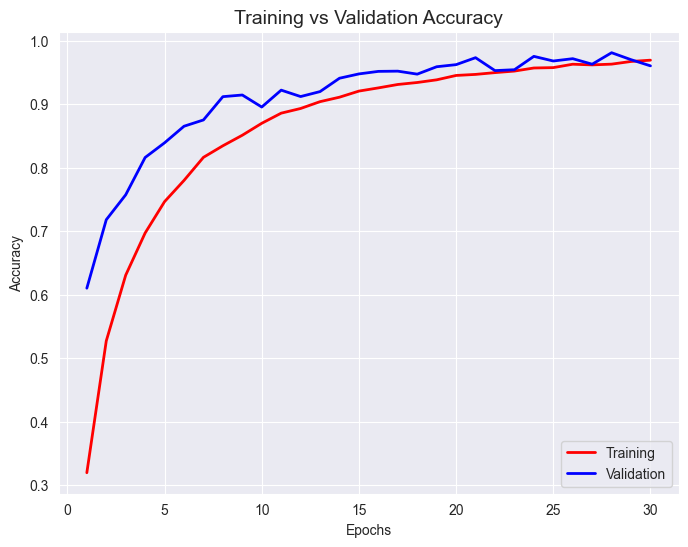

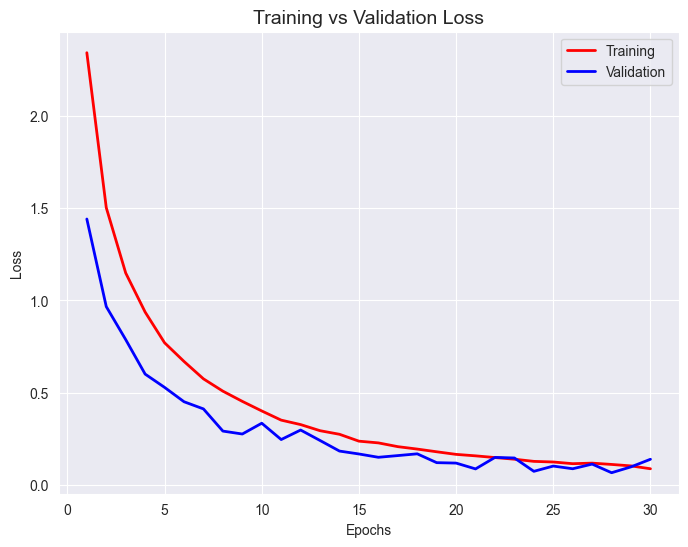

In [26]:
# Ambil metrik dari hasil training
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot akurasi
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'r-', linewidth=2)
plt.plot(epochs, val_acc, 'b-', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'r-', linewidth=2)
plt.plot(epochs, val_loss, 'b-', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()


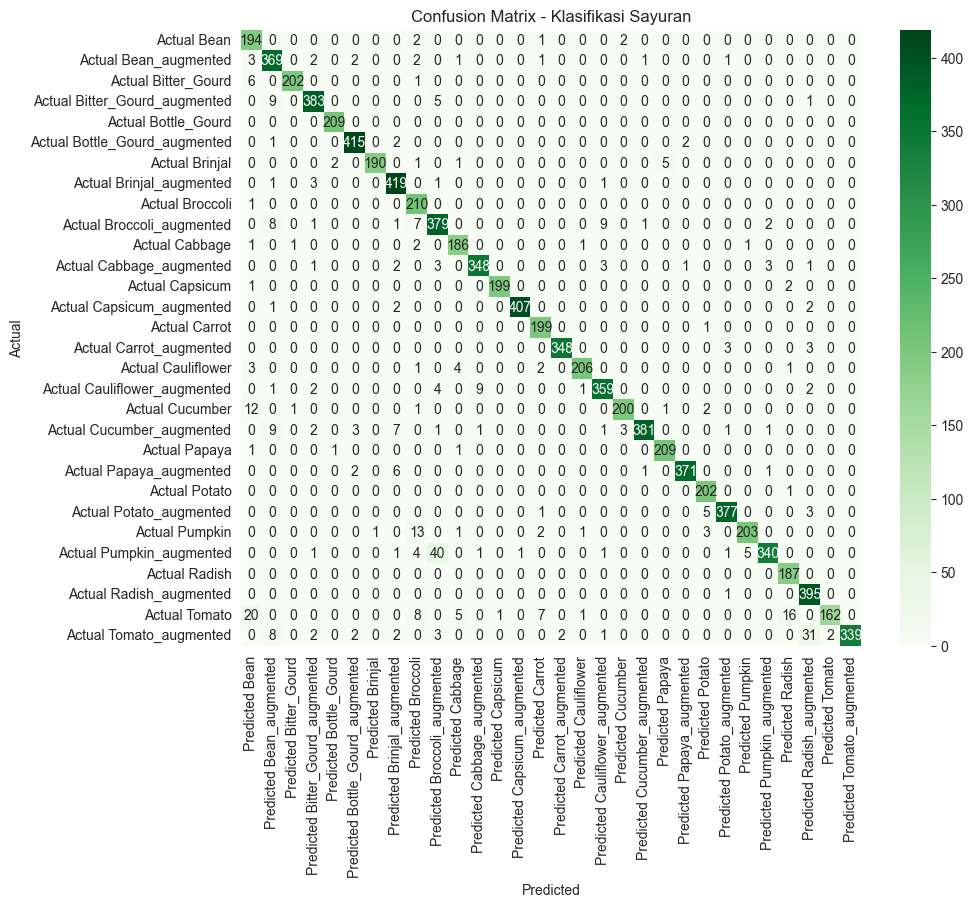


=== Classification Report ===
                        precision    recall  f1-score   support

                  Bean     0.8017    0.9749    0.8798       199
        Bean_augmented     0.9066    0.9660    0.9354       382
          Bitter_Gourd     0.9902    0.9665    0.9782       209
Bitter_Gourd_augmented     0.9647    0.9623    0.9635       398
          Bottle_Gourd     0.9858    1.0000    0.9929       209
Bottle_Gourd_augmented     0.9788    0.9881    0.9834       420
               Brinjal     0.9948    0.9548    0.9744       199
     Brinjal_augmented     0.9480    0.9859    0.9666       425
              Broccoli     0.8333    0.9953    0.9071       211
    Broccoli_augmented     0.8693    0.9289    0.8981       408
               Cabbage     0.9347    0.9688    0.9514       192
     Cabbage_augmented     0.9694    0.9613    0.9653       362
              Capsicum     0.9950    0.9851    0.9900       202
    Capsicum_augmented     0.9975    0.9879    0.9927       412
        

In [27]:

# Reset generator
test_generator.reset()

# Prediksi model
preds_veg = model_1.predict(test_generator, verbose=0)
preds_veg = np.argmax(preds_veg, axis=1)  # gunakan argmax karena multi-class

# Ambil nama kelas dari generator
class_labels = list(test_generator.class_indices.keys())
num_classes = len(class_labels)

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds_veg, labels=range(num_classes))

# Tampilkan dalam bentuk heatmap
cm_df = pd.DataFrame(cm, index=[f"Actual {c}" for c in class_labels],
                         columns=[f"Predicted {c}" for c in class_labels])

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Klasifikasi Sayuran")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_veg,
    target_names=class_labels,
    digits=4
))


In [28]:
# Simpan model dalam format TensorFlow SavedModel
model_1.export("saved_model")


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 30), dtype=tf.float32, name=None)
Captures:
  1389709749488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389709748784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389709739280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389709750720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389709753888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389710328752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389709748432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389709745264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389710328400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389710333856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389710334736: TensorSpec(shape=(), dtype=t

In [29]:
model_1.save("model_1.h5")

d:\Asah\Submision\submission2\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:

model_path = "model_1.h5"
output_dir = "tflite"
os.makedirs(output_dir, exist_ok=True)

model = tf.keras.models.load_model(model_path)


converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_path = os.path.join(output_dir, "model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f" Model TFLite disimpan di: {tflite_path}")


class_names = ["class_1", "class_2", "class_3"] 

label_path = os.path.join(output_dir, "label.txt")
with open(label_path, "w") as f:
    f.write("\n".join(class_names))

print(f" Label disimpan di: {label_path}")


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpf_hsu4od\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpf_hsu4od\assets


 Model TFLite disimpan di: tflite\model.tflite
 Label disimpan di: tflite\label.txt
